# Modeling and Simulation in Python

Case Study: Queueing theory

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [163]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

# set the random number generator
np.random.seed(7)

import matplotlib.pyplot as plt
import numpy as np

## One queue or two?

This notebook presents a solution to an exercise from *Modeling and Simulation in Python*.  It uses features from the first four chapters to answer a question related to queueing theory, which is the study of systems that involve waiting in lines, also known as "queues".

Suppose you are designing the checkout area for a new store.  There is room for two checkout counters and a waiting area for customers.  You can make two lines, one for each counter, or one line that serves both counters.

In theory, you might expect a single line to be better, but it has some practical drawbacks: in order to maintain a single line, you would have to install rope barriers, and customers might be put off by what seems to be a longer line, even if it moves faster.

So you'd like to check whether the single line is really better and by how much.  Simulation can help answer this question.

As we did in the bikeshare model, we'll assume that a customer is equally likely to arrive during any timestep.  I'll denote this probability using the Greek letter lambda, $\lambda$, or the variable name `lam`.  The value of $\lambda$ probably varies from day to day, so we'll have to consider a range of possibilities.

Based on data from other stores, you know that it takes 5 minutes for a customer to check out, on average.  But checkout times are highly variable: most customers take less than 5 minutes, but some take substantially more.  A simple way to model this variability is to assume that when a customer is checking out, they have the same probability of finishing up during each time step.  I'll denote this probability using the Greek letter mu, $\mu$, or the variable name `mu`.

If we choose $\mu=1/5$, the average number of time steps for each checkout will be 5 minutes, which is consistent with the data.

### One server, one queue

Write a function called `make_system` that takes `lam` and `mu` as parameters and returns a `System` object with variables `lam`, `mu`, and `duration`.  Set `duration`, which is the number of time steps to simulate, to 10 hours, expressed in minutes. 

#### I have been working on the principle of writing small chuncks of code and testing them, but my comprehension of the program improves when I can see it all bare-bones and chunked together.  So by the time my notebooks are turned in they are in the chunked-together state, which does a bad job of communicating the process I used to generate the program.  I'm going to try an intermediate process in this notebook and keep both individual steps, but also a progressively larger chunck than encompasses all of the code as it progresses.

In [3]:
minutes = UNITS.minutes
hours = UNITS.hours
duration = 10*hours
duration = duration.to(minutes)

def make_system(lam, mu):
    return System(lam=lam, mu=mu, duration=duration)

Test this function by creating a `System` object with `lam=1/8` and `mu=1/5`.

In [4]:
system = make_system(1/8, 1/5)

,values
lam,0.125
mu,0.2
duration,600.0 minute


Write an update function that takes as parameters `x`, which is the total number of customer in the store, including the one checking out; `t`, which is the number of minutes that have elapsed in the simulation, and `system`, which is a `System` object.

If there's a customer checking out, it should use `flip` to decide whether they are done.  And it should use `flip` to decide if a new customer has arrived.

It should return the total number of customers at the end of the time step.


In [55]:
def update_function(x, t, system):
    if flip(system.lam):
            x+=1
    if x>0:
        if flip(system.mu):
            x-=1
    return x

Test your function by calling it with `x=1`, `t=0`, and the `System` object you created.  If you run it a few times, you should see different results.

In [56]:
minutes = UNITS.minutes
hours = UNITS.hours
duration = 10*hours
duration = duration.to(minutes)

def make_system(lam, mu):
    return System(lam=lam, mu=mu, duration=duration)

def update_function(x, t, system):
        if flip(system.lam):
            x+=1
        if x>0:
            if flip(system.mu):
                x-=1
        return x

In [57]:
system = make_system(1/100, 1/2) 
    #I tested a range of values, but used these to make sure the system never goes negative.

seriestest=Series()
for x in linrange(1, 10):
    seriestest[x]=update_function(1, 0, system)
    
seriestest

1.0     0
2.0     1
3.0     1
4.0     0
5.0     0
6.0     0
7.0     0
8.0     1
9.0     1
10.0    1
dtype: int64

Now we can run the simulation.  Here's a version of `run_simulation` that creates a `TimeSeries` with the total number of customers in the store, including the one checking out.

In [58]:
def run_simulation(system, update_func):
    """Simulate a queueing system.
    
    system: System object
    update_func: function object
    """
    x = 0
    results = TimeSeries()
    results[0] = x
    
    for t in linrange(0, system.duration-1):
        x = update_func(x, system)
        results[t+1] = x

    return results

Call `run_simulation` with your update function and plot the results.

In [108]:
minutes = UNITS.minutes
hours = UNITS.hours
duration = 10*hours
duration = duration.to(minutes)

def make_system(lam, mu):
    return System(lam=lam, mu=mu, duration=duration)

def update_function(x, system):
    #run_simulation now takes care of t, 
    #so technically I could remove it as an argument of this function, 
    #but it ain't doin' no harm.
        if flip(system.lam):
            x+=1
        if x>0:
            if flip(system.mu):
                x-=1
        return x

def run_simulation(system, update_func):
    x = 0
    results = TimeSeries()
    results[0] = x
    
    for t in linrange(0, system.duration.magnitude-1):
        x = update_func(x, system)
        results[t+1] = x

    return results

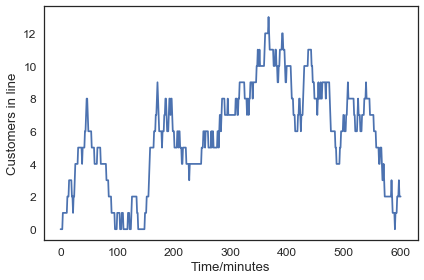

In [109]:
system = make_system(1/5, 1/5) 
results=run_simulation(system, update_function)

plt.plot(results)
decorate(xlabel='Time/minutes', ylabel='Customers in line')

After the simulation, we can compute `L`, which is the average number of customers in the system, and `W`, which is the average time customers spend in the store.  `L` and `W` are related by Little's Law:

$L = \lambda W$

Where $\lambda$ is the arrival rate.  Here's a function that computes them.

In [61]:
def compute_metrics(results, system):
    """Compute average number of customers and wait time.
    
    results: TimeSeries of queue lengths
    system: System object
    
    returns: L, W
    """
    L = results.mean()
    W = L / system.lam
    return L, W

Call `compute_metrics` with the results from your simulation.

In [62]:
compute_metrics(results, system)

(6.717138103161398, 33.58569051580699)

In [63]:
metrics=compute_metrics(results, system)
metrics[1]

33.58569051580699

### Parameter sweep

Since we don't know the actual value of $\lambda$, we can sweep through a range of possibilities, from 10% to 80% of the completion rate, $\mu$.  (If customers arrive faster than the completion rate, the queue grows without bound.  In that case the metrics `L` and `W` just depend on how long the store is open.)

Create an array of values for `lam`.

In [64]:
mu=1/5
lam=linrange(.1*mu, 0.8*mu, 0.1*mu)

array([0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16])

Write a function that takes an array of values for `lam`, a single value for `mu`, and an update function.

For each value of `lam`, it should run a simulation, compute `L` and `W`, and store the value of `W` in a `SweepSeries`.

It should return the `SweepSeries`.

In [65]:
mu=1/5
lam=linrange(.1*mu, 0.8*mu, 0.1*mu)

make_system(lam[1], mu)

,values
lam,0.04
mu,0.2
duration,600.0 minute


In [66]:
minutes = UNITS.minutes
hours = UNITS.hours
duration = 10*hours
duration = duration.to(minutes)

mu=1/5
lam=linrange(.1*mu, 0.8*mu, 0.1*mu)

SweptSimulation = SweepSeries()
for lam in lam:
    system = make_system(lam, mu)
    SweptSimulation[lam] = system.lam 

SweptSimulation

,values
0.02,0.02
0.04,0.04
0.06,0.06
0.08,0.08
0.10,0.10
0.12,0.12
0.14,0.14
0.16,0.16


In [67]:
minutes = UNITS.minutes
hours = UNITS.hours
duration = 10*hours
duration = duration.to(minutes)

mu=1/5
lamrange = linrange(.1*mu, 0.8*mu, 0.1*mu)

def sweepSimulation(system_func):
    SweptSimulation = SweepSeries()
    for lam in lamrange:
        SweptSimulation[lam] = lam
    return SweptSimulation

In [68]:
sweptSimulationResults=sweepSimulation(make_system)

,values
0.02,0.02
0.04,0.04
0.06,0.06
0.08,0.08
0.10,0.10
0.12,0.12
0.14,0.14
0.16,0.16


In [166]:
minutes = UNITS.minutes
hours = UNITS.hours
duration = 10*hours
duration = duration.to(minutes)

mu=1/5
lamrange = linrange(.1*mu, 0.8*mu, 0.1*mu)

def make_system(lam, mu):
    return System(lam=lam, mu=mu, duration=duration)


def update_function(x, system):
        if flip(system.lam):
            x+=1
        if x>0:
            if flip(system.mu):
                x-=1
        return x

def run_simulation(system, update_func):
    x = 0
    results = TimeSeries()
    results[0] = x
    for t in linrange(0, system.duration.magnitude-1):
        x = update_func(x, system)
        results[t+1] = x
    return results

def compute_metrics(results, system):
    L = results.mean()
    W = L / system.lam
    return L, W

def sweepSimulation(system_func, update_func):
    sweepSimulationResults = SweepSeries()
    for lam in lamrange:
        system = system_func(lam, mu)
        results = run_simulation(system, update_func)
        metrics = compute_metrics(results, system)
        sweepSimulationResults[lam]=metrics[1]
    return sweepSimulationResults

Call your function to generate a `SweepSeries`, and plot it.

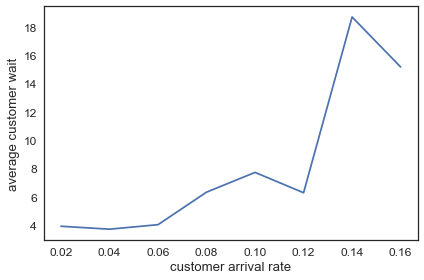

In [167]:
sweepResults=sweepSimulation(make_system, update_function)

plt.plot(sweepResults)
decorate(xlabel='customer arrival rate', ylabel='average customer wait')

If we imagine that this range of values represents arrival rates on different days, we can use the average value of `W`, for a range of values of `lam`, to compare different queueing strategies.

In [170]:
W_avg = sweepResults.mean()
print(W_avg)
W_std = sweepResults.std()
print(W_std)

8.232459789240155
5.64335082831468


### Analysis

The model I chose for this system is a common model in queueing theory, in part because many of its properties can be derived analytically.

In particular, we can derive the average time in the store as a function of $\mu$ and $\lambda$:

$W = 1 / (\mu - \lambda)$

The following function plots the theoretical value of $W$ as a function of $\lambda$.

In [92]:
def plot_W(lam_array, mu):
    """Plot the theoretical mean wait time.
    
    lam_array: array of values for `lam`
    mu: probability of finishing a checkout
    """
    W = 1 / (mu - lam_array)
    plot(lam_array, W, 'g-')

Use this function to plot the theoretical results, then plot your simulation results again on the same graph.  How do they compare?

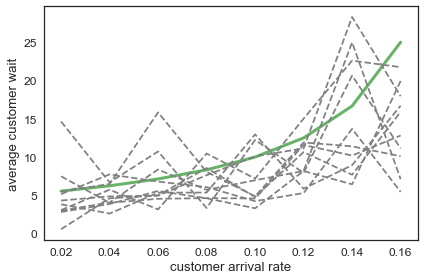

In [94]:
# Given that each simulation yields an average of 600 time points, I'm surprised at the variability.

plot_W(lamrange, mu)

for i in linrange(1,10):
    sweepResults=sweepSimulation(make_system, update_function)
    plt.plot(sweepResults, color='gray', linestyle='dashed')
    
decorate(xlabel='customer arrival rate', ylabel='average customer wait')

### Multiple servers

Now let's try the other two queueing strategies:

1.  One queue with two checkout counters.
2.  Two queues, one for each counter.

The following figure shows the three scenarios:

![](diagrams/queue.png)

Write an update function for one queue with two servers.

In [99]:
def update_function_1q2s(x,t,system):
    if flip(system.lam):
        x+=1
    if x>0:
        if flip(system.mu):
            x-=1
    if x>0:
        if flip(system.mu):
            x-=1
    return x
        

Use this update function to simulate the system, plot the results, and print the metrics.

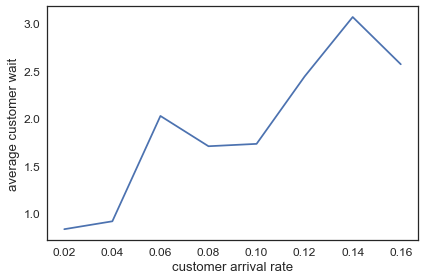

In [102]:
sweepResults=sweepSimulation(make_system, update_function_1q2s)

plt.plot(sweepResults)
decorate(xlabel='customer arrival rate', ylabel='average customer wait')

Since we have two checkout counters now, we can consider values for $\lambda$ that exceed $\mu$.

Create a new array of values for `lam` from 10% to 160% of `mu`.

In [103]:
lamrange = linrange(.1*mu, 1.6*mu, 0.2*mu)

array([0.02  , 0.0575, 0.095 , 0.1325, 0.17  , 0.2075, 0.245 , 0.2825,
       0.32  ])

Use your sweep function to simulate the two server, one queue scenario with a range of values for `lam`.

Plot the results and print the average value of `W` across all values of `lam`.

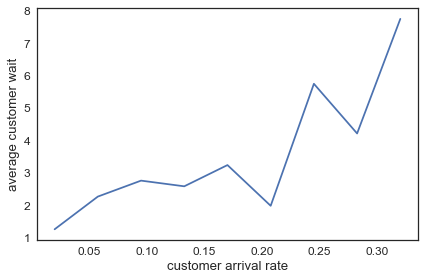

In [104]:
sweepResults=sweepSimulation(make_system, update_function_1q2s)

plt.plot(sweepResults)
decorate(xlabel='customer arrival rate', ylabel='average customer wait')

In [105]:
W_avg_1q2s = sweepResults.mean()

3.524233682532225

### Multiple queues

To simulate the scenario with two separate queues, we need two state variables to keep track of customers in each queue.

Write an update function that takes `x1`, `x2`, `t`, and `system` as parameters and returns `x1` and `x2` as return values.  f you are not sure how to return more than one return value, see `compute_metrics`.

When a customer arrives, which queue do they join?

In [141]:
def update_function_2q2s(x1, x2, system):
    if flip(system.lam):
        if x1<=x2:
            x1+=1
        else:
            x2+=1
    if x1>0:
        if flip(system.mu):
            x1-=1
    if x2>0:
        if flip(system.mu):
            x2-=1
    return x1, x2

Write a version of `run_simulation` that works with this update function.

In [145]:
def run_simulation_2q2s(system, update_func):
    x1=0
    x2=0
    results=TimeSeries()
    results[0]=x1+x2
    for t in linrange(0, system.duration.magnitude-1):
        customers=update_func(x1, x2, system)
        x1=customers[0]
        x2=customers[1]
        results[t+1]=x1+x2
    return results

Test your functions by running a simulation with a single value of `lam`.

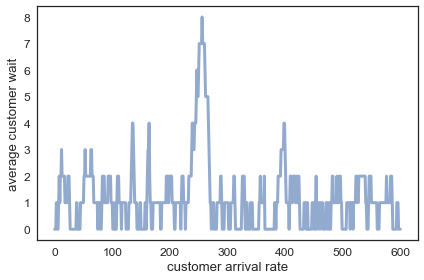

In [146]:
minutes = UNITS.minutes
hours = UNITS.hours
duration = 10*hours
duration = duration.to(minutes)

mu = 1/5
lam = 1/5

system=make_system(lam, mu)
results=run_simulation_2q2s(system, update_function_2q2s)
plot(results)
decorate(xlabel='customer arrival rate', ylabel='average customer wait')

Sweep a range of values for `lam`, plot the results, and print the average wait time across all values of `lam`.

How do the results compare to the scenario with two servers and one queue.

In [158]:
minutes = UNITS.minutes
hours = UNITS.hours
duration = 10*hours
duration = duration.to(minutes)

mu=1/5
lamrange = linrange(.1*mu, 0.8*mu, 0.1*mu)

def make_system(lam, mu):
    return System(lam=lam, mu=mu, duration=duration)


def update_function_2q2s(x1, x2, system):
    if flip(system.lam):
        if x1<=x2:
            x1+=1
        else:
            x2+=1
    if x1>0:
        if flip(system.mu):
            x1-=1
    if x2>0:
        if flip(system.mu):
            x2-=1
    return x1, x2

def run_simulation_2q2s(system, update_func):
    x1=0
    x2=0
    results=TimeSeries()
    results[0]=x1+x2
    for t in linrange(0, system.duration.magnitude-1):
        customers=update_func(x1, x2, system)
        x1=customers[0]
        x2=customers[1]
        results[t+1]=x1+x2
    return results

def compute_metrics(results, system):
    L = results.mean()
    W = L / system.lam
    return L, W

def sweepSimulation(system_func, update_func, run_simulation_func):
    sweepSimulationResults = SweepSeries()
    for lam in lamrange:
        system = system_func(lam, mu)
        results = run_simulation_func(system, update_func)
        metrics = compute_metrics(results, system)
        sweepSimulationResults[lam]=metrics[1]
    return sweepSimulationResults

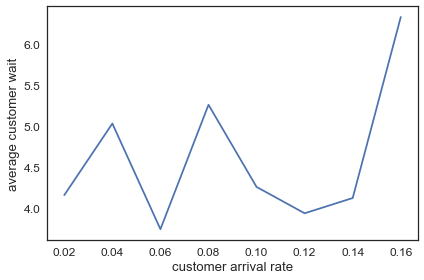

In [159]:
sweepResults=sweepSimulation(make_system, update_function_2q2s, run_simulation_2q2s)

plt.plot(sweepResults)
decorate(xlabel='customer arrival rate', ylabel='average customer wait')

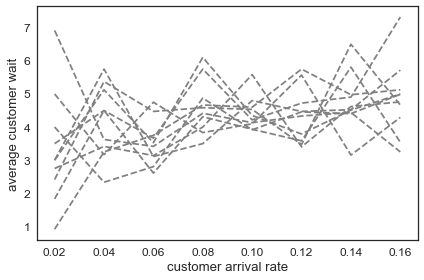

In [160]:
for i in linrange(1,10):
    sweepResults=sweepSimulation_2q2s(make_system, update_function_2q2s, run_simulation_2q2s)
    plt.plot(sweepResults, color='gray', linestyle='dashed')
    
decorate(xlabel='customer arrival rate', ylabel='average customer wait')

---
# Project Summary

## Here is the code for 1 queue 1 server

In [230]:
minutes = UNITS.minutes
hours = UNITS.hours
duration = 10*hours
duration = duration.to(minutes)

mu=1/5
lamrange = linrange(.1*mu, 1.2*mu, 0.1*mu)

def make_system(lam, mu):
    return System(lam=lam, mu=mu, duration=duration)


def update_function_1q1s(x, system):
        if flip(system.lam):
            x+=1
        if x>0:
            if flip(system.mu):
                x-=1
        return x

def run_simulation_1q(system, update_func):
    x = 0
    results = TimeSeries()
    results[0] = x
    for t in linrange(0, system.duration.magnitude-1):
        x = update_func(x, system)
        results[t+1] = x
    return results

def compute_metrics(results, system):
    L = results.mean()
    W = L / system.lam
    return L, W

def sweepSimulation(system_func, update_func, run_simulation_func):
    sweepSimulationResults = SweepSeries()
    for lam in lamrange:
        system = system_func(lam, mu)
        results = run_simulation_func(system, update_func)
        metrics = compute_metrics(results, system)
        sweepSimulationResults[lam]=metrics[1]
    return sweepSimulationResults

### Because there is so much variability in individual simulations, I'll base a comparison on 10 trials

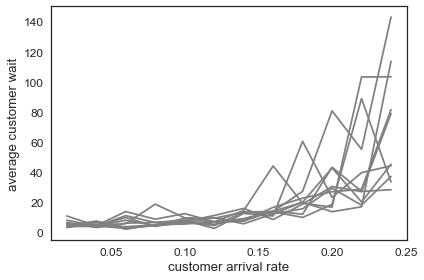

In [292]:
trials=10
compiledSweepResults_1q1s=np.zeros((trials, len(lamrange)))

for i in linrange(0,trials-1):
    sweepData=sweepSimulation(make_system, update_function_1q1s, run_simulation_1q)
    compiledSweepResults_1q1s[int(i)]=sweepData
    plt.plot(sweepData, color='gray')
    
decorate(xlabel='customer arrival rate', ylabel='average customer wait')

## And the code and results for 1 queue, 2 servers

In [263]:
def update_function_1q2s(x, system):
    if flip(system.lam):
        x+=1
    if x>0:
        if flip(system.mu):
            x-=1
    if x>0:
        if flip(system.mu):
            x-=1
    return x

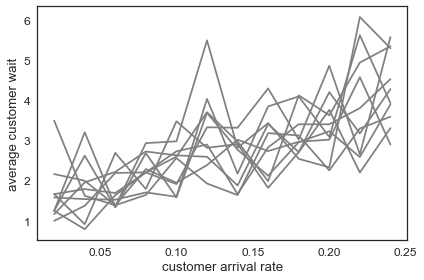

In [314]:
trials=10
compiledSweepResults_1q2s=np.zeros((trials, len(lamrange)))

for i in linrange(0,trials-1):
    sweepData=sweepSimulation(make_system, update_function_1q2s, run_simulation_1q)
    compiledSweepResults_1q2s[int(i)]=sweepData
    plt.plot(sweepData, color='gray')
    
decorate(xlabel='customer arrival rate', ylabel='average customer wait')

## ...2 queues 2 servers...

In [266]:
def update_function_2q2s(x1, x2, system):
    if flip(system.lam):
        if x1<=x2:
            x1+=1
        else:
            x2+=1
    if x1>0:
        if flip(system.mu):
            x1-=1
    if x2>0:
        if flip(system.mu):
            x2-=1
    return x1, x2

def run_simulation_2q2s(system, update_func):
    x1=0
    x2=0
    results=TimeSeries()
    results[0]=x1+x2
    for t in linrange(0, system.duration.magnitude-1):
        customers=update_func(x1, x2, system)
        x1=customers[0]
        x2=customers[1]
        results[t+1]=x1+x2
    return results

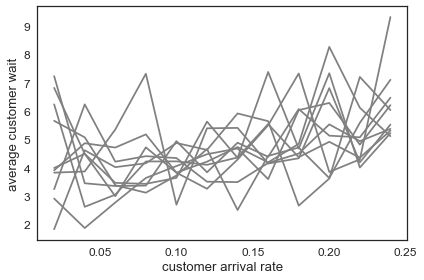

In [315]:
trials=10
compiledSweepResults_2q2s=np.zeros((trials, len(lamrange)))

for i in linrange(0,trials-1):
    sweepData=sweepSimulation(make_system, update_function_2q2s, run_simulation_2q2s)
    compiledSweepResults_2q2s[int(i)]=sweepData
    plt.plot(sweepData, color='gray')
    
decorate(xlabel='customer arrival rate', ylabel='average customer wait')

## ...and lastly, here is compiled data to present to the store manager:

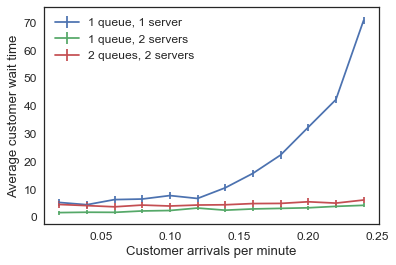

In [316]:
avg_1q1s=np.zeros(len(lamrange))
std_1q1s=np.zeros(len(lamrange))
avg_1q2s=np.zeros(len(lamrange))
std_1q2s=np.zeros(len(lamrange))
avg_2q2s=np.zeros(len(lamrange))
std_2q2s=np.zeros(len(lamrange))

for i in linrange(0,len(lamrange)-1):
    avg_1q1s[int(i)]=np.average(compiledSweepResults_1q1s[:,int(i)])
    std_1q1s[int(i)]=np.std(compiledSweepResults_1q1s[:,int(i)])
    avg_1q2s[int(i)]=np.average(compiledSweepResults_1q2s[:,int(i)])
    std_1q2s[int(i)]=np.std(compiledSweepResults_1q2s[:,int(i)])
    avg_2q2s[int(i)]=np.average(compiledSweepResults_2q2s[:,int(i)])
    std_2q2s[int(i)]=np.std(compiledSweepResults_2q2s[:,int(i)])

fig, ax = plt.subplots()
plt.errorbar(lamrange, avg_1q1s, yerr=std_1q1s[1], label='1 queue, 1 server')
plt.errorbar(lamrange, avg_1q2s, yerr=std_1q2s[1], label='1 queue, 2 servers')
plt.errorbar(lamrange, avg_2q2s, yerr=std_2q2s[1], label='2 queues, 2 servers')
ax.set_xlabel('Customer arrivals per minute')
ax.set_ylabel('Average customer wait time')
plt.legend()